In [1]:
import torch, os, cv2, numpy as np, matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
video_id = 810                     # example video index
video_path = f"data/videos/case_{video_id:03d}.mp4"
label_path = f"outputs/labels/val/case_{video_id:03d}.npy"

gt = np.load(label_path)
print("Ground-truth frames:", len(gt))


Ground-truth frames: 5538


In [7]:
def resize_videomae_pos_embed(model, new_temporal_len=32, new_size=(224, 224)):
    """
    Fully safe VideoMAE positional embedding resizer.
    Works even if pretrained grid is non-integer (e.g. 7.84×14×14).
    """
    pos_embed = model.videomae.embeddings.position_embeddings  # [1, N, D]
    embed_dim = pos_embed.shape[-1]
    pos_tokens = pos_embed[:, 1:, :]  # drop cls token
    num_patches_old = pos_tokens.shape[1]

    patch_size = model.config.patch_size
    tubelet_size = model.config.tubelet_size
    img_size = model.config.image_size
    old_spatial = img_size // patch_size

    # infer temporal dimension as float, then round safely
    old_temporal_f = num_patches_old / (old_spatial * old_spatial)
    old_temporal = int(round(old_temporal_f))
    print(f"ℹ️ Inferred temporal={old_temporal_f:.3f} → rounded to {old_temporal}")

    # pad or trim to make reshape valid
    needed = old_temporal * old_spatial * old_spatial
    if needed > num_patches_old:
        pad = needed - num_patches_old
        pos_tokens = torch.cat([pos_tokens, pos_tokens[:, :pad, :]*0], dim=1)
        print(f"⚙️ Padded {pad} tokens to fit reshape grid ({needed})")
    elif needed < num_patches_old:
        pos_tokens = pos_tokens[:, :needed, :]
        print(f"⚙️ Trimmed {num_patches_old - needed} tokens to fit reshape grid ({needed})")

    # reshape + interpolate
    pos_tokens = pos_tokens.reshape(1, old_temporal, old_spatial, old_spatial, embed_dim).permute(0, 4, 1, 2, 3)
    new_temporal = new_temporal_len // tubelet_size
    new_spatial = new_size[0] // patch_size
    print(f"ℹ️ Target grid: T={new_temporal}, H={new_spatial}, W={new_spatial}")

    pos_tokens = F.interpolate(
        pos_tokens,
        size=(new_temporal, new_spatial, new_spatial),
        mode="trilinear",
        align_corners=False
    )

    pos_tokens = pos_tokens.permute(0, 2, 3, 4, 1).reshape(1, -1, embed_dim)
    model.videomae.embeddings.position_embeddings = torch.nn.Parameter(pos_tokens)
    print(f"✅ Resized pos_embed: {num_patches_old} → {pos_tokens.shape[1]}")

print("Done ✅")

Done ✅


In [10]:
from transformers import VideoMAEForVideoClassification
import torch.nn.functional as F

def build_swin(num_classes=10, pretrained=True):
    model_name = "MCG-NJU/videomae-base"
    print(f"🔹 Loading pretrained VideoMAE model: {model_name}")

    model = VideoMAEForVideoClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
    )
    return model

    
model_swin = build_swin(num_classes=10)
resize_videomae_pos_embed(model_swin, new_temporal_len= 32, new_size=(224, 224))
model_swin.load_state_dict(torch.load("outputs_swin/swin_best.pth"))
model_swin = model_swin.to(device).eval()
print("✅ Swin model loaded")


🔹 Loading pretrained VideoMAE model: MCG-NJU/videomae-base


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ℹ️ Inferred temporal=7.995 → rounded to 8
⚙️ Padded 1 tokens to fit reshape grid (1568)
ℹ️ Target grid: T=16, H=14, W=14
✅ Resized pos_embed: 1567 → 3136
✅ Swin model loaded


In [18]:
import torch
import numpy as np
import cv2
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224, antialias=True),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
])

@torch.inference_mode()
def predict_swin(video_path, model, clip_len=32, step=16, transform=None, device="cuda"):
    cap = cv2.VideoCapture(video_path)
    frames = []

    # --- Read and preprocess frames ---
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = transform(frame)            # expects a torchvision transform
        frames.append(frame)
    cap.release()

    preds = []
    for i in range(0, len(frames) - clip_len + 1, step):
        clip = torch.stack(frames[i:i+clip_len]).unsqueeze(0).to(device)  # ✅ [1, T, C, H, W]
        with torch.no_grad():
            yhat = model(clip)
            yhat = yhat.logits if hasattr(yhat, "logits") else yhat
            p = yhat.softmax(1).cpu().numpy()[0]
        preds.extend([np.argmax(p)] * step)

    return np.array(preds[:len(frames)])


pred_swin = predict_swin(video_path, model_swin, transform=transform, device=device)

print("✅ Swin predictions:", len(pred_swin))

✅ Swin predictions: 11184


In [21]:
from torch import nn

class DilatedResidualLayer(nn.Module):
    def __init__(self, in_channels, dilation):
        super().__init__()
        self.conv_dil = nn.Conv1d(in_channels, in_channels, 3,
                                  padding=dilation, dilation=dilation)
        self.conv_1x1 = nn.Conv1d(in_channels, in_channels, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.conv_dil(x)
        out = self.relu(out)
        out = self.conv_1x1(out)
        return out + x

class ASFormer(nn.Module):
    def __init__(self, in_dim=512, num_classes=10,
                 d_model=256, n_heads=4, n_blocks=2):
        super().__init__()
        self.input_proj = nn.Conv1d(in_dim, d_model, 1)
        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=2*d_model, dropout=0.1,
            activation='gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(enc, num_layers=n_blocks)
        self.residuals = nn.Sequential(
            DilatedResidualLayer(d_model,1),
            DilatedResidualLayer(d_model,2),
            DilatedResidualLayer(d_model,4)
        )
        self.classifier = nn.Conv1d(d_model, num_classes, 1)
    def forward(self, x):   # [B,C,T]
        x = x.transpose(1,2)
        x = self.input_proj(x.transpose(1,2)).transpose(1,2)
        x = self.transformer(x)
        x = x.transpose(1,2)
        x = self.residuals(x)
        return self.classifier(x)

print("Done ✅")

Done ✅


In [22]:

model_asf = ASFormer(in_dim=512, num_classes=10)
model_asf.load_state_dict(torch.load("outputs/models/asformer_best.pth"))
model_asf = model_asf.to(device).eval()
print("✅ ASFormer model loaded")


✅ ASFormer model loaded


In [23]:
from torchvision.models import resnet18
resnet = resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet = resnet.to(device).eval()

def extract_features(video_path, step=2):
    cap = cv2.VideoCapture(video_path)
    feats = []
    while True:
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = transform(frame).unsqueeze(0).to(device)
        with torch.no_grad():
            f = resnet(frame).squeeze().cpu().numpy()
        feats.append(f)
        for _ in range(step-1): cap.grab()
    cap.release()
    return np.stack(feats)

X_feat = extract_features(video_path)
X_tensor = torch.tensor(X_feat.T, dtype=torch.float32).unsqueeze(0).to(device)  # [1,C,T]

with torch.no_grad():
    yhat = model_asf(X_tensor).squeeze(0).cpu().numpy()
pred_asf = yhat.argmax(0)
print("ASFormer predictions:", len(pred_asf))


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ASFormer predictions: 5602


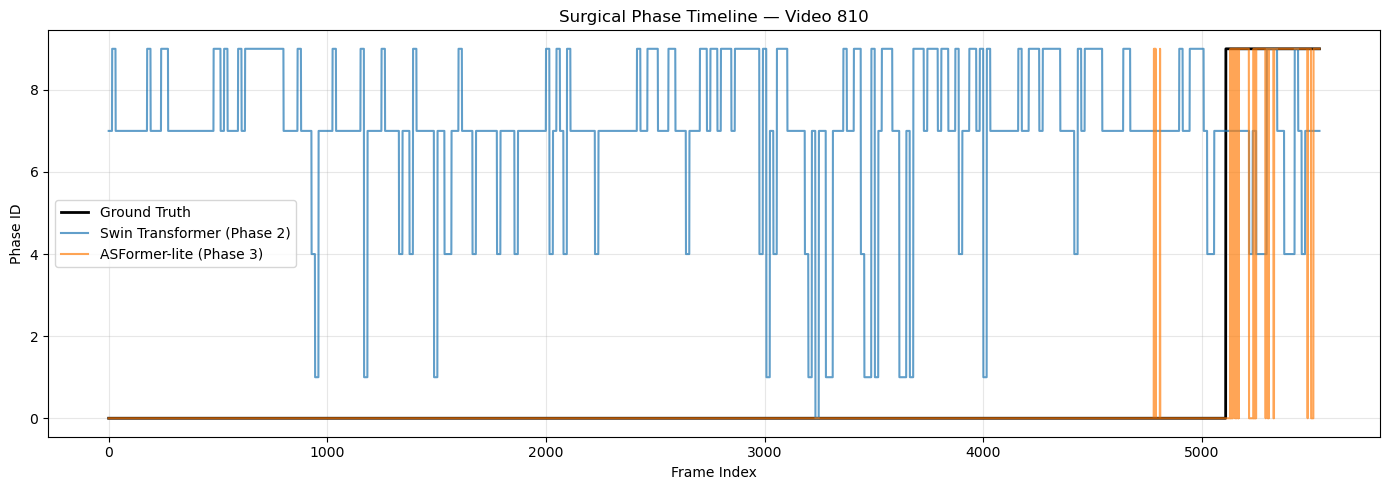

In [24]:
T = min(len(gt), len(pred_swin), len(pred_asf))
gt, pred_swin, pred_asf = gt[:T], pred_swin[:T], pred_asf[:T]

plt.figure(figsize=(14,5))
plt.plot(gt, lw=2, color='black', label='Ground Truth')
plt.plot(pred_swin, lw=1.5, alpha=0.7, label='Swin Transformer (Phase 2)')
plt.plot(pred_asf, lw=1.5, alpha=0.7, label='ASFormer-lite (Phase 3)')
plt.xlabel("Frame Index"); plt.ylabel("Phase ID")
plt.title(f"Surgical Phase Timeline — Video {video_id:03d}")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


In [25]:
from sklearn.metrics import accuracy_score, f1_score

acc_swin = accuracy_score(gt, pred_swin)
f1_swin  = f1_score(gt, pred_swin, average='macro')
acc_asf  = accuracy_score(gt, pred_asf)
f1_asf   = f1_score(gt, pred_asf, average='macro')

print(f"Swin Transformer  →  Acc={acc_swin:.3f}, F1={f1_swin:.3f}")
print(f"ASFormer-lite     →  Acc={acc_asf:.3f}, F1={f1_asf:.3f}")


Swin Transformer  →  Acc=0.014, F1=0.014
ASFormer-lite     →  Acc=0.984, F1=0.937


In [29]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

out_path = f"outputs/visualizations/case_{video_id:03d}_compare.mp4"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h + 120))

# ✅ Fixed: specify `lut` as keyword argument
cmap = plt.get_cmap('tab10', int(np.max(gt) + 1))

def color_for_label(l):
    rgb = np.array(cmap(l)[:3]) * 255
    bgr = rgb[::-1].astype(np.uint8)
    return tuple(bgr.tolist())

T = min(len(gt), len(pred_swin), len(pred_asf))

for i in tqdm(range(T)):
    ret, frame = cap.read()
    if not ret:
        break
    bar = np.zeros((120, w, 3), dtype=np.uint8)
    cv2.rectangle(bar, (0, 0), (w, 40), color_for_label(gt[i]), -1)
    cv2.rectangle(bar, (0, 40), (w, 80), color_for_label(pred_swin[i]), -1)
    cv2.rectangle(bar, (0, 80), (w, 120), color_for_label(pred_asf[i]), -1)
    cv2.putText(bar, "GT / Swin / ASFormer", (20, 110),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    writer.write(np.vstack([frame, bar]))

cap.release()
writer.release()
print(f"🎥 Saved visualization video → {out_path}")


100% 5538/5538 [00:18<00:00, 304.98it/s]

🎥 Saved visualization video → outputs/visualizations/case_810_compare.mp4


In [31]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# (optional) define class names — otherwise numeric labels will be used
CLASS_NAMES = [
    "Phase 1", "Phase 2", "Phase 3", "Phase 4", "Phase 5",
    "Phase 6", "Phase 7", "Phase 8", "Phase 9", "Phase 10"
]

out_path = f"outputs/visualizations/case_{video_id:03d}_compare.mp4"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h + 120))

# ✅ Colormap (compatible with all matplotlib versions)
cmap = plt.get_cmap('tab10', int(np.max(gt) + 1))

def color_for_label(l):
    rgb = np.array(cmap(l)[:3]) * 255
    bgr = rgb[::-1].astype(np.uint8)
    return tuple(bgr.tolist())

T = min(len(gt), len(pred_swin), len(pred_asf))

for i in tqdm(range(T)):
    ret, frame = cap.read()
    if not ret:
        break

    bar = np.zeros((120, w, 3), dtype=np.uint8)

    # ---- Draw colored bars ----
    cv2.rectangle(bar, (0, 0), (w, 40), color_for_label(gt[i]), -1)
    cv2.rectangle(bar, (0, 40), (w, 80), color_for_label(pred_swin[i]), -1)
    cv2.rectangle(bar, (0, 80), (w, 120), color_for_label(pred_asf[i]), -1)

    # ---- Text labels ----
    gt_label = CLASS_NAMES[gt[i]] if gt[i] < len(CLASS_NAMES) else str(gt[i])
    swin_label = CLASS_NAMES[pred_swin[i]] if pred_swin[i] < len(CLASS_NAMES) else str(pred_swin[i])
    asf_label = CLASS_NAMES[pred_asf[i]] if pred_asf[i] < len(CLASS_NAMES) else str(pred_asf[i])

    cv2.putText(bar, f"GT: {gt_label}", (20, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
    cv2.putText(bar, f"Swin: {swin_label}", (20, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
    cv2.putText(bar, f"ASFormer: {asf_label}", (20, 110),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

    # Combine frame + annotation bar
    writer.write(np.vstack([frame, bar]))

cap.release()
writer.release()
print(f"🎥 Saved visualization video → {out_path}")


100% 5538/5538 [00:18<00:00, 305.12it/s]

🎥 Saved visualization video → outputs/visualizations/case_810_compare.mp4
